# Data Preprocessing

## Importing the libraries

In [46]:
import pandas as pd
import numpy as np
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA

import warnings

warnings.filterwarnings('ignore')

## Load the dataset

In [47]:
from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')

df_origin = pd.read_csv('games-regression-dataset.csv', parse_dates=['Original Release Date' , 'Current Version Release Date'], date_parser=dateparse)

## Download the icons

In [ ]:
# Convert to string
df_origin['Icon URL'] = df_origin['Icon URL'].astype(str)

import requests
import os
import shutil


def download_image(url, filename):
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(filename, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)


# Create a folder to store the images
if not os.path.exists('icons'):
    os.makedirs('icons')

# Download the images
for i, row in df_origin.iterrows():
    download_image(row['Icon URL'], f'icons/{i}.png')

In [48]:
# Replace the URL with the icon filename which is the index of the row
df_origin['Icon URL'] = df_origin.apply(lambda row : f'icons/{row.name}.png', axis=1)

In [49]:
sentiment = pd.read_csv('average_reviews_compound.csv')
## Merge The Sentiment with ba2i el table
df_origin = df_origin.merge(sentiment, on='ID', how='left')
## Drop nulls of sentiment
df_origin = df_origin.dropna(subset=['Reviews'])
df_origin.shape


(2750, 19)

## Data Splitting

In [50]:
from sklearn.model_selection import train_test_split

df, df_test = train_test_split(df_origin, test_size=0.2, random_state=42)
df_test.to_csv('df_test.csv', index=False)

In [51]:
df.shape

(2200, 19)

## Dropping unnecessary columns

In [52]:
# drop Primary Genre
df.drop(['Primary Genre','ID', 'URL'], axis=1, inplace=True)

In [57]:
df

,Name,Subtitle,Icon URL,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Genres,Original Release Date,Current Version Release Date,Average User Rating,Reviews
4427,Jump Numbers,Use math to save the Snortles!,icons/4427.png,204,2.99,NaN,"""Kids are so excited about saving the Snortles...",Artgig Studio,4+,EN,197940224,"Education, Strategy, Games",2016-02-24,2018-01-08,4.5,0.674490
3621,For Freedom,NaN,icons/3621.png,25,0.00,"0.99, 0.99, 9.99, 9.99, 4.99, 21.99, 19.99, 4....","For Freedom, a 2016 fantasy-themed strategy wa...",Dragonest,9+,"EN, DE, JA, KO, PL, ZH, ES, ZH",139696128,"Games, Role Playing, Strategy",2017-01-06,2017-04-27,2.0,0.239856
378,Command & Colours: The Great War,NaN,icons/378.png,15,9.99,NaN,HexWar Games has partnered with Plastic Soldie...,HexWar Games Ltd,12+,EN,190210048,"Games, Entertainment, Strategy, Board",2017-03-23,2017-08-24,3.0,0.553092
4696,Checkers \u2023,The best Checkers around!,icons/4696.png,1542,0.00,6.99,Hands down the best Checkers for iOS!\n\nTired...,Banana & Co.,4+,EN,53391360,"Games, Strategy, Board",2016-02-08,2017-10-24,4.5,0.424040
4202,Just Solitaire: La Belle Lucie,NaN,icons/4202.png,84,0.00,NaN,"""Challenging enough to get you hooked and winn...","CleverMedia, Inc.",4+,EN,29378560,"Games, Card, Entertainment, Strategy",2014-08-05,2017-11-20,4.5,0.596030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3068,Alien Dog Evolution - Wild Stray Mutant Simulator,NaN,icons/3068.png,1633,0.00,"1.99, 1.99, 4.99, 5.99, 0.99, 9.99, 19.99, 1.9...","""\u2022\u2022\u2022\u2022\u2022\u2022\u2022\u2...",HU YANRUI,9+,"AR, CA, CS, DA, NL, EN, FI, FR, DE, EL, HE, HU...",75151360,"Games, Family, Entertainment, Strategy",2016-03-16,2017-08-14,5.0,0.642520
2050,"""Eric's Spider Solitaire Lite""",Challenging and fun!,icons/2050.png,6147,0.00,NaN,Eric\'s Spider Solitaire Lite includes four Sp...,Eric Snider,4+,EN,54165504,"Games, Entertainment, Card, Strategy",2010-05-31,2017-09-16,2.5,0.478583
2122,Catchup - Abstract Strategy,NaN,icons/2122.png,43,2.99,NaN,Catchup is a simple game of surprising turnaro...,Martin Grider,4+,"NL, EN, FR, DE, RU, ZH, ES, ZH",5702656,"Games, Strategy, Board",2014-08-07,2018-03-07,5.0,0.791260
2421,Super Gem Quest 2 Blast Mania,Jewel match 3 puzzle game.,icons/2421.png,379,0.00,"5.99, 3.99, 0.99, 1.99, 17.99, 9.99, 7.99, 1.9...",Classic Jewels Quest (Jewel Quest) game return...,Miik Limited,4+,EN,86076416,"Games, Strategy, Entertainment, Puzzle",2015-03-21,2018-03-29,5.0,0.802030


## Dates preprocessing

In [53]:
# Convert the datetime to ordinal

df['Original Release Date'] = df['Original Release Date'].apply(lambda x: x.toordinal())
df['Current Version Release Date'] = df['Current Version Release Date'].apply(lambda x: x.toordinal())
df[['Original Release Date', 'Current Version Release Date']].head()

,Original Release Date,Current Version Release Date
4427,736018,736702
3621,736335,736446
378,736411,736565
4696,736002,736626
4202,735450,736653


In [54]:
# Create a new column with the age of the game
df['game_age'] = df['Current Version Release Date'] - df['Original Release Date']

# Create a new column with the time since the last update
df['last_update'] = datetime.now().toordinal() - df['Current Version Release Date'] 

df[['game_age', 'last_update']].head()

,game_age,last_update
4427,684,1928
3621,111,2184
378,154,2065
4696,624,2004
4202,1203,1977


## Data Exploration

### General information

In [24]:
df.head()

,URL,ID,Name,Subtitle,Icon URL,User Rating Count,Price,In-app Purchases,Description,Developer,...,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date,Average User Rating,game_age,last_update,Reviews
0,https://apps.apple.com/us/app/digfender/id9572...,957253933,Digfender,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,348,0.0,"3.99, 1.99, 3.99, 7.99, 4.99, 1.99, 9.99, 5.99...","""Digfender is easily one of the best tower def...",Mugshot Games Pty Ltd,...,[EN],479550464,Games,"[Games, Strategy, Puzzle]",735920,736359,5.0,439,2271,0.781220
1,https://apps.apple.com/us/app/towermadness-zer...,335249553,TowerMadness Zero,Classic Defense Strategy,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,95466,0.0,"1.99, 1.99, 1.99, 2.99, 1.99, 1.99, 1.99, 1.99...","""Addictive, time-sucking fun. There are plenty...",Limbic Software,...,"[EN, DE]",58547200,Games,"[Games, Puzzle, Strategy]",733705,736758,4.0,3053,1872,0.633882
4,https://apps.apple.com/us/app/neo-scavenger/id...,1132258364,NEO Scavenger,Post-apocalyptic survival RPG,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,147,0.0,9.99,Play the acclaimed PC survival RPG on your tab...,"Blue Bottle Games, LLC",...,[EN],117317632,Games,"[Games, Entertainment, Role Playing, Strategy]",736536,736661,4.0,125,1969,0.427540
6,https://apps.apple.com/us/app/city-island-buil...,684194665,City Island - Building Tycoon - Citybuilding Sim,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,1579,0.0,"2.99, 2.99, 1.99, 2.99, 7.99, 2.99, 7.99, 2.99...","If you liked the early Sim City games, you wil...",Sparkling Society,...,"[AR, DA, NL, EN, FR, DE, ID, IT, JA, KO, MS, N...",86935552,Games,"[Games, Simulation, Entertainment, Strategy]",735129,736298,4.5,1169,2332,0.649970
8,https://apps.apple.com/us/app/underworld-empir...,555150599,Underworld Empire,The BEST crime syndicate game,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,21896,0.0,"19.99, 4.99, 9.99, 99.99, 49.99, 4.99",-==THE BEST ONLINE CRIME SYNDICATE GAME!==-\n-...,Gaea Mobile Ltd,...,"[EN, FR, DE, IT, JA, KO, PT, RU, ZH, ES, ZH, TR]",105290752,Games,"[Games, Strategy, Entertainment, Role Playing]",734882,737269,4.5,2387,1361,0.367427


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2195 entries, 0 to 4168
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   URL                           2195 non-null   object 
 1   ID                            2195 non-null   int64  
 2   Name                          2195 non-null   object 
 3   Subtitle                      834 non-null    object 
 4   Icon URL                      2195 non-null   object 
 5   User Rating Count             2195 non-null   int64  
 6   Price                         2195 non-null   float64
 7   In-app Purchases              1437 non-null   object 
 8   Description                   2195 non-null   object 
 9   Developer                     2195 non-null   object 
 10  Age Rating                    2195 non-null   object 
 11  Languages                     2195 non-null   object 
 12  Size                          2195 non-null   int64  
 13  Primary 

In [60]:
df.isnull().sum()

Name                               0
Subtitle                        1357
Icon URL                           0
User Rating Count                  0
Price                              0
In-app Purchases                 787
Description                        0
Developer                          0
Age Rating                         0
Languages                          1
Size                               0
Genres                             0
Original Release Date              0
Current Version Release Date       0
Average User Rating                0
Reviews                            0
game_age                           0
last_update                        0
dtype: int64

### Genres

In [62]:
df['Genres'] = df['Genres'].astype(str)
df['Genres'] = df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

genre_counts = df.explode('Genres').groupby('Genres').size().sort_values(ascending=False)
genre_counts


Genres
Games                  2200
Strategy               2200
Entertainment          1160
Simulation              396
Puzzle                  347
Action                  298
Board                   292
Role Playing            256
Card                    123
Casual                  109
Education               104
Adventure                99
Sports                   91
Family                   88
Trivia                   22
Utilities                22
Social Networking        18
Lifestyle                13
Reference                12
Word                     11
Music                    11
Casino                   11
Food & Drink              9
Health & Fitness          8
Racing                    7
News                      6
Productivity              6
Books                     6
Finance                   5
Travel                    5
Business                  3
Photo & Video             2
Gaming                    1
Emoji & Expressions       1
Stickers                  1
Medical      

### Developer

In [63]:
df['Developer'].value_counts()

Developer
Tapps Tecnologia da Informa\xe7\xe3o Ltda.    68
HexWar Games Ltd                              21
EASY Inc.                                     15
Kairosoft Co.,Ltd                             14
HeroCraft Ltd.                                13
                                              ..
Jacques Deul                                   1
Gideon Greenspan                               1
Blue Wizard Digital LP                         1
Jiri Bukovjan                                  1
Martin Grider                                  1
Name: count, Length: 1376, dtype: int64

In [64]:
df['Developer'].unique().size

1376

### Languages

In [65]:
df['Languages'] = df['Languages'].astype(str)

df['Languages'] = df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")

langs_counts = df.explode('Languages').groupby('Languages').size().sort_values(ascending=False)
print(langs_counts[1:30])

Languages
ZH    969
DE    587
FR    565
ES    541
JA    527
RU    493
IT    455
PT    432
KO    424
TR    264
NL    238
PL    231
SV    186
TH    153
ID    145
DA    145
CS    135
FI    126
NB    125
VI    121
EL    115
AR    112
MS     98
HE     86
HU     82
RO     80
SK     78
CA     66
UK     66
dtype: int64


array([[<Axes: title={'center': 'ID'}>,
        <Axes: title={'center': 'User Rating Count'}>,
        <Axes: title={'center': 'Price'}>],
       [<Axes: title={'center': 'Size'}>,
        <Axes: title={'center': 'Original Release Date'}>,
        <Axes: title={'center': 'Current Version Release Date'}>],
       [<Axes: title={'center': 'Average User Rating'}>,
        <Axes: title={'center': 'game_age'}>,
        <Axes: title={'center': 'last_update'}>],
       [<Axes: title={'center': 'Reviews'}>, <Axes: >, <Axes: >]],
      dtype=object)

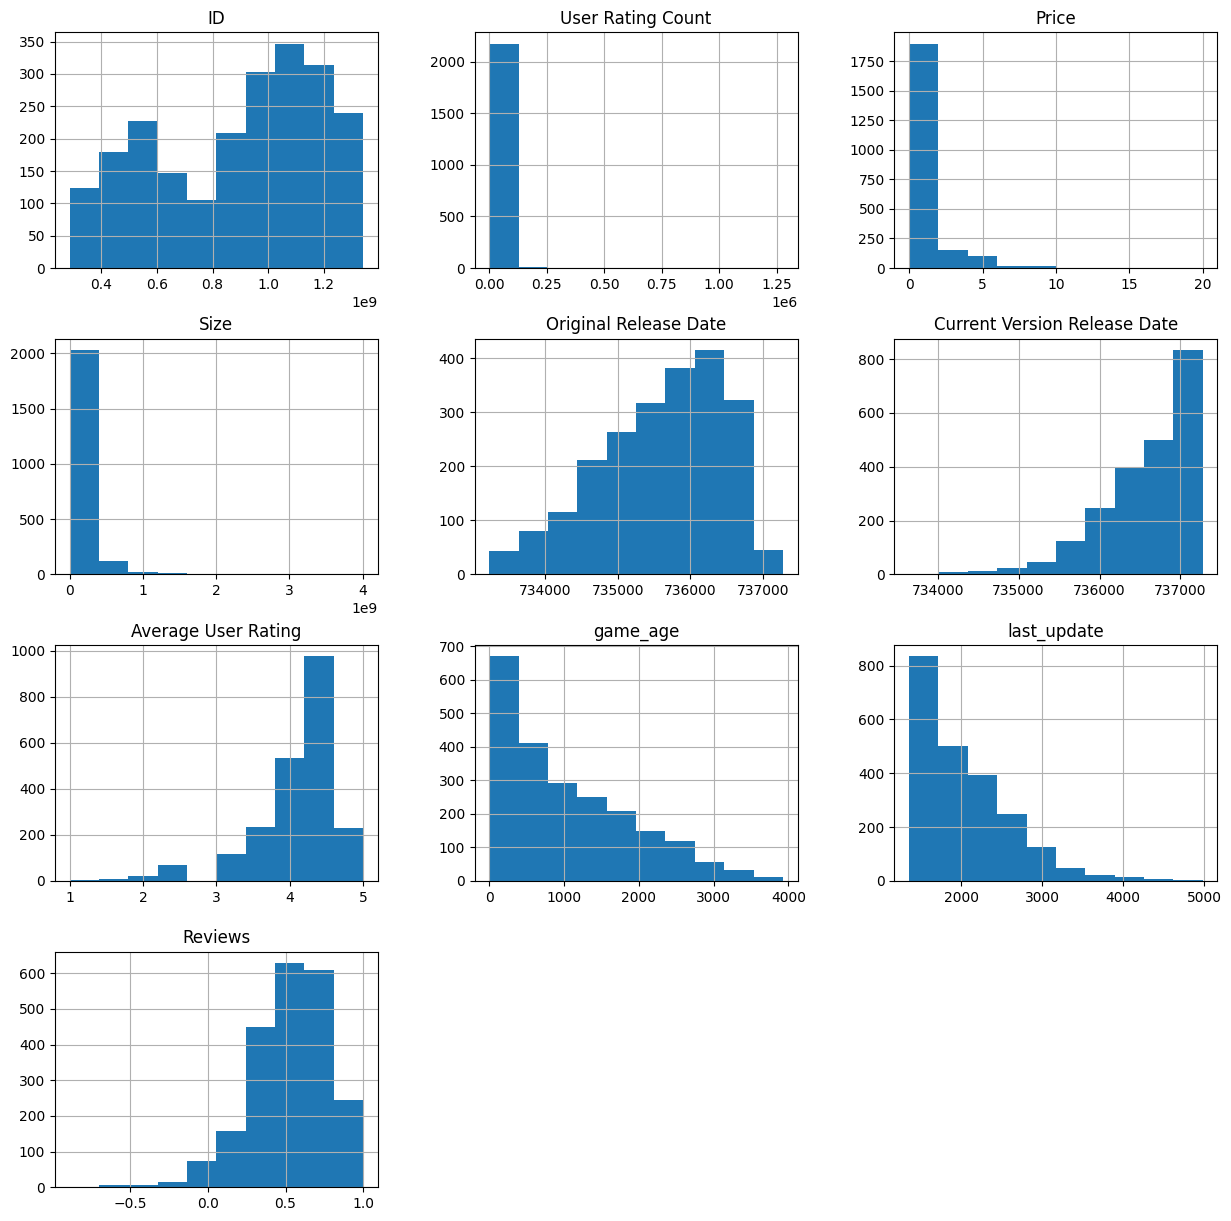

In [30]:
df.hist(figsize=(15, 15))

## Developer preprocessing

In [55]:
# Convert to string
df['Developer'] = df['Developer'].astype(str)
df['Developer'] = df['Developer'].str.replace("'", "").str.strip('[]')

# Replace the developer names with less than 3 games with 'Other'
dev_counts = df['Developer'].value_counts()
other = dev_counts[dev_counts < 3].index
df['Developer'] = df['Developer'].replace(other, 'Other')

dev_df = df[['Developer', 'Average User Rating']].groupby('Developer').mean()

# Save dev_df to be used on the test set
dev_df.to_csv('encoders/dev_df.csv')

# Replace the developer names with the average user rating from dev_df
df['Developer'] = df['Developer'].replace(dev_df.index, dev_df['Average User Rating'])

## Genres preprocessing

### 1. NLP approach

In [15]:
# Convert the genres column to a list of strings
df['Genres'] = df['Genres'].astype(str)
df['Genres'] = df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

# drop Games, Strategy, Entertainment from the Genres column
df['Genres'] = df['Genres'].apply(lambda x: [genre for genre in x if genre not in ['Games', 'Strategy', 'Entertainment']])

# Join the list of genres into a single string
genres = df['Genres'].apply(lambda x: ' '.join(x))

# Create a count Vectorizer and fit it to the genres
count_vec = CountVectorizer()
bow_genres = count_vec.fit_transform(genres)

# Apply principal component analysis to reduce the dimensionality
pca = PCA(n_components=10)
pca_genres = pca.fit_transform(bow_genres.toarray())

# Add the PCA-transformed genres to the original dataframe
for i in range(len(pca_genres[0])):
    df[f'Genre_PCA_{i}'] = pca_genres[:, i]

# Drop the original column
df = df.drop(['Genres'], axis=1)

### 2. Dummy variables approach

In [56]:
# Convert the genres column to a list of strings
df['Genres'] = df['Genres'].astype(str)
df['Genres'] = df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

# drop Games, Strategy, Entertainment from the Genres column
df['Genres'] = df['Genres'].apply(lambda x: [genre for genre in x if genre not in ['Games', 'Strategy', 'Entertainment']])

# Replace genres with counts less than 100 with 'infrequent' as it would represent a very small percentage of the data (less than 2%)
other = df['Genres'].explode().value_counts()[df['Genres'].explode().value_counts() < 100].index
df['Genres'] = df['Genres'].apply(lambda x: [genre if genre not in other else 'infrequent' for genre in x])

# Get dummy variables for the genres
genres = pd.get_dummies(df['Genres'].apply(pd.Series).stack(), prefix="genre", dummy_na=False).sum(level=0)

# Save the genres dummies to be used on the test set
genres.to_csv('encoders/genres.csv', index=False)

# Add the dummy variables to the original dataframe
df = pd.concat([df, genres], axis=1)

# Drop the original column
df = df.drop(['Genres'], axis=1)

# Fill NaN with 0
genre_cols = [col for col in df.columns if col.startswith('genre')] # get all columns with prefix 'genre'
df[genre_cols] = df[genre_cols].fillna(0) # fill NaN with 0 for selected columns

### 3. Multi-label binarizer

In [ ]:
# Convert the genres column to a list of strings
df['Genres'] = df['Genres'].astype(str)
df['Genres'] = df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

# drop Games, Strategy, Entertainment from the Genres column
df['Genres'] = df['Genres'].apply(lambda x: [genre for genre in x if genre not in ['Games', 'Strategy', 'Entertainment']])

# Replace genres with counts less than 100 with 'infrequent' as it would represent a very small percentage of the data (less than 2%)
other = df['Genres'].explode().value_counts()[df['Genres'].explode().value_counts() < 100].index
df['Genres'] = df['Genres'].apply(lambda x: [genre if genre not in other else 'infrequent_genre' for genre in x])

# Instantiate the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit the MultiLabelBinarizer to the genres
mlb.fit(df['Genres'])

# Drop nan from the classes
mlb.classes_ = np.delete(mlb.classes_, np.where(mlb.classes_ == 'nan'))

# Save the mlb for later use with the test data
pickle.dump(mlb, open('encoders/mlb_genres.pkl', 'wb'))

# Transform the genres into a one-hot encoded array
genres_mlb = mlb.transform(df['Genres'])

# Create a dataframe from the one-hot encoded array
genres_mlb_df = pd.DataFrame(genres_mlb, columns=mlb.classes_)

# Add the one-hot encoded genres to the original dataframe
df = pd.concat([df, genres_mlb_df], axis=1)

# Drop the original column
df = df.drop(['Genres'], axis=1)

## Languages preprocessing

### 1. NLP approach

In [16]:
# Convert the langs column to a list of strings
df['Languages'] = df['Languages'].astype(str)
df['Languages'] = df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")

# Drop the English language from the Languages column
df['Languages'] = df['Languages'].apply(lambda x: [lang for lang in x if lang not in ['EN']])

# Join the list of langs into a single string
languages = df['Languages'].apply(lambda x: ' '.join(x))

# Create a count Vectorizer and fit it to the langs
count_vec = CountVectorizer()
bow_languages = count_vec.fit_transform(languages)

# Apply principal component analysis to reduce the dimensionality
pca = PCA(n_components=10)
pca_languages = pca.fit_transform(bow_languages.toarray())

# Add the PCA-transformed langs to the original dataframe
for i in range(len(pca_languages[0])):
    df[f'Languages_PCA_{i}'] = pca_languages[:, i]

# Drop the original column
df = df.drop(['Languages'], axis=1)

print(df.shape)

df.iloc[:, 15:].head()

(2195, 37)


,game_age,last_update,Genre_PCA_0,Genre_PCA_1,Genre_PCA_2,Genre_PCA_3,Genre_PCA_4,Genre_PCA_5,Genre_PCA_6,Genre_PCA_7,...,Languages_PCA_0,Languages_PCA_1,Languages_PCA_2,Languages_PCA_3,Languages_PCA_4,Languages_PCA_5,Languages_PCA_6,Languages_PCA_7,Languages_PCA_8,Languages_PCA_9
0,439,2271,-0.191173,-0.153500,-0.607555,0.635837,-0.019810,-0.107295,-0.006804,-0.089787,...,-0.800362,0.010413,0.155700,-0.012345,-0.006046,0.029035,0.008605,0.003874,-0.004505,0.010810
1,3053,1872,-0.191173,-0.153500,-0.607555,0.635837,-0.019810,-0.107295,-0.006804,-0.089787,...,-0.534094,-0.278620,-0.044835,0.131544,0.057126,-0.195692,-0.239123,-0.051788,0.243395,-0.166205
4,125,1969,-0.377379,1.232448,0.252919,0.094709,0.009996,-0.058518,-0.006908,-0.000842,...,-0.800362,0.010413,0.155700,-0.012345,-0.006046,0.029035,0.008605,0.003874,-0.004505,0.010810
6,1169,2332,-0.301006,-0.442022,0.683519,0.152858,0.001978,-0.074679,-0.006694,-0.034967,...,3.585831,0.152812,0.525536,0.319862,-0.279349,1.215672,-0.525748,-0.099130,0.509222,0.299115
8,2387,1361,-0.377379,1.232448,0.252919,0.094709,0.009996,-0.058518,-0.006908,-0.000842,...,2.364661,0.147263,-1.355419,0.062542,-0.033378,0.189058,0.355586,0.145510,-0.289211,-0.324981


### 2. Dummy variables approach

In [57]:
# Convert the langs column to a list of strings
df['Languages'] = df['Languages'].astype(str)
df['Languages'] = df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")

# Create a column with the number of languages supported
df['langs_count'] = df['Languages'].apply(lambda x: len(x))

# Drop the English language from the Languages column (it is the most common language and would dominate the model)
df['Languages'] = df['Languages'].apply(lambda x: [lang for lang in x if lang not in ['EN']])

# Replace langs with counts less than 500 with 'infrequent_langs' as it would represent a very small percentage of the data (less than 10%)
other = df['Languages'].explode().value_counts()[df['Languages'].explode().value_counts() < 500].index
df['Languages'] = df['Languages'].apply(lambda x: [lang if lang not in other else 'infrequent' for lang in x])

# Get dummy variables for the langs
langs = pd.get_dummies(df['Languages'].apply(pd.Series).stack(), prefix='lang', dummy_na=False).sum(level=0)

langs.to_csv('encoders/langs.csv', index=False)

# Add the dummy variables to the original dataframe
df = pd.concat([df, langs], axis=1)

# Drop the original column
df = df.drop(['Languages'], axis=1)

# Fill NaN with 0
lang_cols = [col for col in df.columns if col.startswith('lang')] # get all columns with prefix 'lang'
df[lang_cols] = df[lang_cols].fillna(0) # fill NaN with 0 for selected columns

### 3. Multi-label binarizer

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Convert the langs column to a list of strings
df['Languages'] = df['Languages'].astype(str)
df['Languages'] = df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")

# Create a column with the number of languages supported
df['langs_count'] = df['Languages'].apply(lambda x: len(x))

# Drop the English language from the Languages column (it is the most common language and would dominate the model)
df['Languages'] = df['Languages'].apply(lambda x: [lang for lang in x if lang not in ['EN']])

# Replace langs with counts less than 500 with 'infrequent_langs' as it would represent a very small percentage of the data (less than 10%)
other = df['Languages'].explode().value_counts()[df['Languages'].explode().value_counts() < 400].index
df['Languages'] = df['Languages'].apply(lambda x: [lang if lang not in other else 'infrequent_lang' for lang in x])

# Instantiate the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit the MultiLabelBinarizer to the langs
mlb.fit(df['Languages'])

# Drop nan from the classes
mlb.classes_ = np.delete(mlb.classes_, np.where(mlb.classes_ == 'nan'))

# Save the mlb for later use with the test data
pickle.dump(mlb, open('encoders/mlb_langs.pkl', 'wb'))

# Transform the langs into a one-hot encoded array
langs_mlb = mlb.transform(df['Languages'])

# Create a dataframe from the one-hot encoded array
langs_mlb_df = pd.DataFrame(langs_mlb, columns=mlb.classes_)

# Add the encoded langs to the original dataframe
df = pd.concat([df, langs_mlb_df], axis=1)

# Drop the original column
df = df.drop(['Languages'], axis=1)

In [59]:
df.head()

,Name,Subtitle,Icon URL,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Size,...,genre_Role Playing,genre_Simulation,genre_infrequent,langs_count,lang_DE,lang_ES,lang_FR,lang_JA,lang_ZH,lang_infrequent
4427,Jump Numbers,Use math to save the Snortles!,icons/4427.png,204,2.99,NaN,"""Kids are so excited about saving the Snortles...",4.500000,4+,197940224,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
3621,For Freedom,NaN,icons/3621.png,25,0.00,"0.99, 0.99, 9.99, 9.99, 4.99, 21.99, 19.99, 4....","For Freedom, a 2016 fantasy-themed strategy wa...",4.093882,9+,139696128,...,1.0,0.0,0.0,8,1.0,1.0,0.0,1.0,2.0,2.0
378,Command & Colours: The Great War,NaN,icons/378.png,15,9.99,NaN,HexWar Games has partnered with Plastic Soldie...,3.523810,12+,190210048,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
4696,Checkers \u2023,The best Checkers around!,icons/4696.png,1542,0.00,6.99,Hands down the best Checkers for iOS!\n\nTired...,4.093882,4+,53391360,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
4202,Just Solitaire: La Belle Lucie,NaN,icons/4202.png,84,0.00,NaN,"""Challenging enough to get you hooked and winn...",4.300000,4+,29378560,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0


## In-app Purchases preprocessing

In [60]:
# Free apps might skew the in-app purchases column,
# so we might split the dataset into free and paid apps

df['In-app Purchases'] = df['In-app Purchases'].astype(str)
df['In-app Purchases'] = df['In-app Purchases'].str.strip('[]').str.replace("'", "").str.split(", ")

In [61]:
# Convert to float
df['In-app Purchases'] = df['In-app Purchases'].apply(lambda x: [float(i) for i in x])

# Get the number of in-app purchases
df['purchases_count'] = df['In-app Purchases'].apply(lambda x: len(x))

# Get the lowest, highest and average purchase
df['lowest_purchase'] = df['In-app Purchases'].apply(lambda x: min(x) if len(x) > 0 else 0)
df['highest_purchase'] = df['In-app Purchases'].apply(lambda x: max(x) if len(x) > 0 else 0)
df['average_purchase'] = df['In-app Purchases'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)


In [62]:
# Drop the original column
df = df.drop(['In-app Purchases'], axis=1)

df['lowest_purchase'] = df['lowest_purchase'].fillna(0)
df['highest_purchase'] = df['highest_purchase'].fillna(0)
df['average_purchase'] = df['average_purchase'].fillna(0)

## Age Rating preprocessing

In [63]:
# Convert to string
df['Age Rating'] = df['Age Rating'].astype(str)

# Remove the + sign
df['Age Rating'] = df['Age Rating'].str.replace('+', '')

# Convert to int
df['Age Rating'] = df['Age Rating'].astype(float)

## NLP preprocessing

In [65]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from textblob import TextBlob
import re

def preprocess_nlp(col):
    df[col] = df[col].astype(str)

    # Remove URLs and email addresses
    df[col] = df[col].apply(lambda x: re.sub(r'http\S+|www.\S+|\S+@\S+', '', x))

    # Remove the punctuation, numbers, and convert to lowercase
    df[col] = df[col].apply(lambda x: " ".join(re.findall(r'\w+', x.lower())))

    # Remove the stopwords
    stop = stopwords.words('english')
    df[col] = df[col].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

    # Stemming
    st = nltk.PorterStemmer()
    df[col] = df[col].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

    # Lemmatization
    lem = nltk.WordNetLemmatizer()
    df[col] = df[col].apply(lambda x: " ".join([lem.lemmatize(word) for word in x.split()]))

    # Remove the frequent and rare words
    freq = pd.Series(' '.join(df[col]).split()).value_counts()
    common_freq = list(freq[:10].index)
    rare_freq = list(freq[-10:].index)
    df[col] = df[col].apply(lambda x: " ".join(x for x in x.split() if x not in common_freq+rare_freq))

    # Remove the whitespaces
    df[col] = df[col].apply(lambda x: " ".join(x.strip() for x in x.split()))

    # Replace NaN values with empty string
    df[col] = df[col].fillna('')

    # Convert text data to bag-of-words representation
    vectorizer = CountVectorizer()
    BoW = vectorizer.fit_transform(df[col])

    # Apply principal component analysis to reduce the dimensionality
    pca_ = PCA(n_components=2)
    pca_col = pca_.fit_transform(BoW.toarray())
    
    # Save the vectorizer and pca for later use with the test data
    pickle.dump(vectorizer, open(f'encoders/vectorizer_{col}.pkl', 'wb'))
    pickle.dump(pca_, open(f'encoders/pca_{col}.pkl', 'wb'))

    # Add the PCA-transformed col to the original dataframe
    for feat in range(len(pca_col[0])):
        df[f'{col}_PCA_{feat}'] = pca_col[:, feat]



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [66]:
preprocess_nlp('Description')
preprocess_nlp('Subtitle')
preprocess_nlp('Name')

df = df.drop(['Description', 'Subtitle', 'Name'], axis=1)

df.head()

,Icon URL,User Rating Count,Price,Developer,Age Rating,Size,Original Release Date,Current Version Release Date,Average User Rating,Reviews,...,purchases_count,lowest_purchase,highest_purchase,average_purchase,Description_PCA_0,Description_PCA_1,Subtitle_PCA_0,Subtitle_PCA_1,Name_PCA_0,Name_PCA_1
4427,icons/4427.png,204,2.99,4.500000,4.0,197940224,736018,736702,4.5,0.674490,...,1,0.00,0.00,0.00,-0.033106,-0.232023,-0.019115,-0.033887,-0.017331,-0.033414
3621,icons/3621.png,25,0.00,4.093882,9.0,139696128,736335,736446,2.0,0.239856,...,10,0.99,21.99,8.49,-0.177898,-0.247181,-0.011635,-0.025236,-0.026041,-0.025511
378,icons/378.png,15,9.99,3.523810,12.0,190210048,736411,736565,3.0,0.553092,...,1,0.00,0.00,0.00,-0.250177,-0.196724,-0.011635,-0.025236,-0.027858,-0.036262
4696,icons/4696.png,1542,0.00,4.093882,4.0,53391360,736002,736626,4.5,0.424040,...,1,6.99,6.99,6.99,-0.211783,-0.160200,-0.054622,0.051989,-0.033766,-0.034888
4202,icons/4202.png,84,0.00,4.300000,4.0,29378560,735450,736653,4.5,0.596030,...,1,0.00,0.00,0.00,-0.204408,-0.169842,-0.011635,-0.025236,-0.062510,-0.100647


## Icon preprocessing

### Extract features from the icons

In [67]:
import cv2

def preprocess_icon(img_path):
    # Load the game icon image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (100, 100))

    # Extract color features using color histograms
    colors = ('b', 'g', 'r')
    color_features = []
    for k, col in enumerate(colors):
        hist = cv2.calcHist([img], [k], None, [256], [0, 256])
        color_features.append(hist)

    # Reshape the color features to have a single dimension
    color_features = np.concatenate(color_features).ravel()

    # Extract shape features using edge detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_features = np.array(edges).flatten()

    # Combine the color and shape features into a single feature vector
    feature_vector = np.concatenate((color_features, edge_features))

    # Normalize the feature vector to have unit length
    normalized_feature_vector = feature_vector / np.linalg.norm(feature_vector)
    
    return normalized_feature_vector


In [68]:
from tqdm import tqdm

# Create a list to store the feature vectors
icon_features = []

df['Icon URL'] = df['Icon URL'].astype(str)

# Iterate over the images and extract the features
for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    feature_vec = preprocess_icon(row['Icon URL'])
    icon_features.append((row['Icon URL'], feature_vec))
    
# Apply PCA to reduce the number of features
pca = PCA(n_components=4)
pca.fit([f[1] for f in icon_features])
reduced_features = pca.transform([f[1] for f in icon_features])

# Save the pca instance for later use
pickle.dump(pca, open('encoders/icon_pca.pkl', 'wb'))

# Convert the reduced features to a dataframe
icon_features_df = pd.DataFrame({'Icon URL': [f[0] for f in icon_features],
                                    'Icon1': reduced_features[:,0],
                                    'Icon2': reduced_features[:,1],
                                    'Icon3': reduced_features[:,2],
                                    'Icon4': reduced_features[:,3]})

100%|██████████| 2200/2200 [00:07<00:00, 285.06it/s]


### Add the icon features to the dataset

In [69]:
# Merge the icon features with the original dataframe on the icon URL
df = df.merge(icon_features_df, on='Icon URL', how='left')

# Drop the icon URL column
df = df.drop(['Icon URL'], axis=1)

In [70]:
# Save the preprocessed data
df.to_csv('preprocessed_data.csv', index=False)

## Scaling and Model Training

In [71]:
import pandas as pd
df = pd.read_csv('preprocessed_data.csv')

In [72]:
df_x = df.drop(['Average User Rating'], axis=1)
df_y = df['Average User Rating']

In [ ]:
df_x.shape

### Feature Scaling

In [73]:
# print only the columns with nan values and their count
print(df_x.isnull().sum()[df_x.isnull().sum() > 0])

Series([], dtype: int64)


In [30]:
# Scale the features
from sklearn.preprocessing import StandardScaler

cols = df_x.columns

scaler = StandardScaler()
df_x = scaler.fit_transform(df_x)

df_x = pd.DataFrame(df_x, columns=cols)

# Save the scaler
pickle.dump(scaler, open('scalers/std_scaler.pkl', 'wb'))

In [74]:
from sklearn.preprocessing import MinMaxScaler

cols = df_x.columns

scaler = MinMaxScaler()
df_x = scaler.fit_transform(df_x)

df_x = pd.DataFrame(df_x, columns=cols)

# Save the scaler
pickle.dump(scaler, open('scalers/min_max_scaler.pkl', 'wb'))

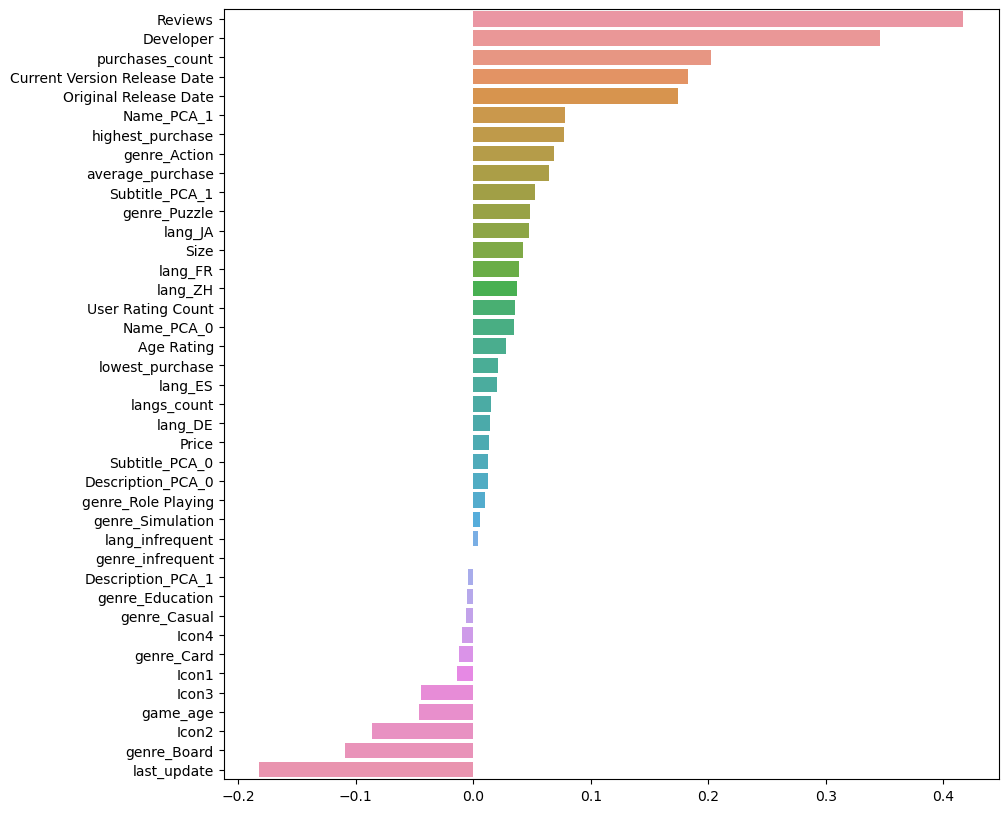

In [75]:
# plot correlation matrix between features and target
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_x.corrwith(df_y)
corr = corr.sort_values(ascending=False)
plt.figure(figsize=(10, 10))
sns.barplot(x=corr.values, y=corr.index)
plt.show()

### Feature Selection

In [76]:
# Feature selection
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=10)
df_x_select =  selector.fit_transform(df_x, df_y)

# Save the selector
pickle.dump(selector, open('encoders/selector.pkl', 'wb'))

In [77]:
# Print the selected features
for i in range(len(selector.get_support())): 
    if selector.get_support()[i]:
        print(df_x.columns[i])

Developer
Original Release Date
Current Version Release Date
Reviews
last_update
genre_Board
purchases_count
highest_purchase
Name_PCA_1
Icon2


### Linear Regression

In [78]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures


In [79]:
# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(df_x_select, df_y)

# Save the model
pickle.dump(model, open('models/LR_model.pkl', 'wb'))


### Ridge Regression

In [80]:
# Create a ridge regression model
model = Ridge(alpha=20)

# Train the model
model.fit(df_x_select, df_y)

# Save the model
pickle.dump(model, open('models/Ridge_model.pkl', 'wb'))


### Lasso Regression

In [81]:
# Create a lasso regression model
model = Lasso(alpha=0.001)

# Train the model
model.fit(df_x_select, df_y)

# Save the model
pickle.dump(model, open('models/Lasso_model.pkl', 'wb'))


### Elastic Net Regression

In [82]:
# Create an elastic net regression model
model = ElasticNet(alpha=0.001)

# Train the model
model.fit(df_x_select, df_y)

# Save the model
pickle.dump(model, open('models/ElasticNet_model.pkl', 'wb'))


### Polynomial Regression

In [83]:
# Create a polynomial regression model
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(df_x_select)

# Save the polynomial features
pickle.dump(poly, open('encoders/poly.pkl', 'wb'))

# Train the model
model = LinearRegression()
model.fit(X_train_poly, df_y)

# Save the model
pickle.dump(model, open('models/Polynomial_model.pkl', 'wb'))
